# Spam Detection in Text Messages

Unsupervised Machine Learning Project

DTSA 5510 Final Project

###Project Description

This project centers on unsupervised machine learning algorithms and unwanted text messages.

Goal of this project is to produce an acceptable unsupervised model that detects spam texts messages.

###Steps:

1. Description of the unsupervised learning problem
2. Exploratory Data Analysis
3. Model analysis: building and training the model
4. Optimizations
5. Results
6. Discussion and conclusion

###1: Description of the unsupervised learning problem

Spam texts are unwanted text messages that are potentially sent by harmful people or organizations. Spam is a nusance at best, and can lead to fraudulent transactions or harmful interactions at worst. They are a bad thing, so finding a technological way to filter them out before they show up on a phone can be very beneficial.

People are getting personal cell phones at younger ages now. This [recent article about parenting](https://www.parents.com/parents-getting-kids-smartphone-before-they-are-ready-11777744) sheds light on how parents are pressured to give a phone to their children even when they feel it is too early. Thus, protecting children from bad actors is becoming increasingly important.

In this project, I test the efficacy of an unsupevised machine learning algorithm on detecting whether or not a text message is spam and not-spam.

"*Not-spam*" is my wording because not all non-spam messages are good, they are just not spam.   

The unsupervised learning aspect focuses on using patterns in text messages (short text strings) to train a model that can be used to protect phone users from toxicity, or from being annoyed. The end goal is to help phone software developers to embed a layer of filtering so that spam does not reach the user.

###2: Exploratory Data Analysis

The goals of EDA include: acquiring an appropriate dataset, exploring the data to understand at a high level.

The actions include checking for and deleting duplicates, check for empty values, adding more data if needed, and transforming the data if appropriate. I will use visualizations to display findings.

First, import necessary libraries

In [43]:
import math
import pandas as pd
import sklearn.metrics
import numpy as np
import matplotlib.pyplot as plt
import sklearn.feature_extraction.text
import sklearn.model_selection
import sklearn.preprocessing
from sklearn.decomposition import NMF
import sklearn.preprocessing
from sklearn.metrics import accuracy_score
import sklearn.ensemble
import warnings
from sklearn.exceptions import ConvergenceWarning
%matplotlib inline

#### Data Acquisition

Data was made available by Kaggle at https://www.kaggle.com/datasets/team-ai/spam-text-message-classification.

Downloaded data as csv file, stored locally.

In [24]:
df = pd.read_csv('/content/SPAM text.csv')

###Step 1: Exploratory Data Analysis

Inspect, Visualize and Clean the Data


Explore data, assess findings, and prepare data for training. This includes cleaning, filling in gaps, and vectorizing text so that it is ready for model ingestion.

In [84]:
# high level look into training dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


The original dataset comes with around 5500 labeled text messages.

In [85]:
# see sample of the data
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


There are no columns to drop. The data also has appropriately named columns.

"**spam**" == bad

"**ham**" == okay, not spam

In [103]:
# data cleaning: check for empty values and duplicates
df.isna().sum()

,0
Category,0
Message,0


Superb, there are no empty values.

In [106]:
# data cleaning: detect for duplicates
dupes = (df.duplicated(subset= "Message")).sum()
print("Number of duplicates: ", dupes)

Number of duplicates:  415


Some duplicates were found. 415 out of 5572 means around 7% of the dataset will be removed. This leaves plenty of data to work with.

In [25]:
# delete existing duplicates from training set
df = df.drop_duplicates(subset=["Message"])

# check to see if duplicates were removed
dupes = (df.duplicated(subset="Message")).sum()
print("Remaining duplicates: ", dupes)
df.info()

Remaining duplicates:  0
<class 'pandas.core.frame.DataFrame'>
Index: 5157 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5157 non-null   object
 1   Message   5157 non-null   object
dtypes: object(2)
memory usage: 120.9+ KB


Next, I inspect the distribution of samples across categories. In this case there are two categories so ideally it is balanced (50% each).

Text(0.5, 1.0, 'Total Number Text Messages Per Spam Category')

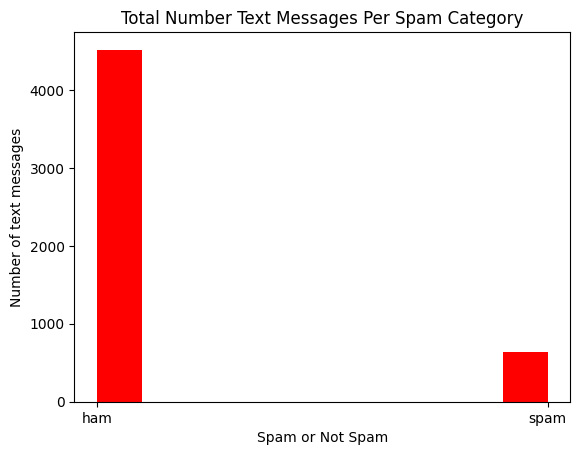

In [108]:
# visualize the distribution of messages across the two categories
plt.hist(df['Category'], color='red')
plt.xlabel("Spam or Not Spam")
plt.ylabel("Number of text messages")
plt.title("Total Number Text Messages Per Spam Category")

There are far more not-spam messages than there are spam. This is very imbalanced, but this is also reflective of reality; most people get far more non-spam messages than they do spam, hopefully at least. Overall this should be workable.

Next, I inspect the average text message length for each category. The average text length tells me how much data there is for each sample in each category. Ideally this is balanced.

Text(0.5, 1.0, 'Average Length of Text Message Per Spam Category')

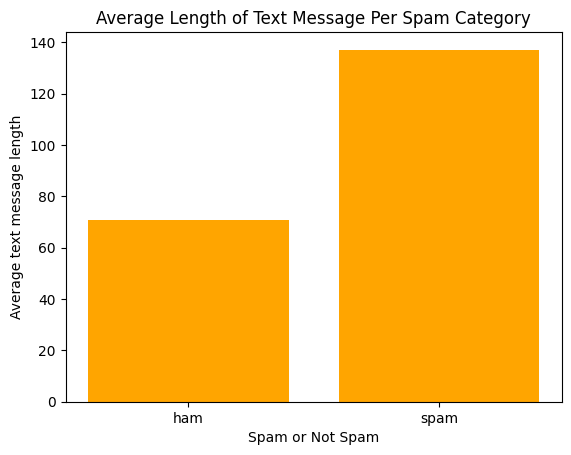

In [111]:
# Visualization of average length of message for each category
spam=0
spam_count=0
notspam=0
notspam_count=0
for i, row in df.iterrows():
  if row['Category'] == "ham":
    notspam += len(row['Message'])
    notspam_count += 1
  if row['Category'] == "spam":
    spam += len(row['Message'])
    spam_count += 1

avg_text = [notspam/notspam_count, spam/spam_count]
spammy = ['ham', 'spam']
plt.bar(spammy, avg_text, color='orange')
plt.ylabel("Average text message length")
plt.xlabel("Spam or Not Spam")
plt.title("Average Length of Text Message Per Spam Category")

It looks like spam messages are significantly longer than non-spam messages, almost twice as long, on average. This stark difference may be considered by the model.

In [26]:
# Extract word features. Converts text into data that is useful for modeling.
# Using TF-IDF method to process text into features.

# TfidfVectorizer uses parameter norm='l2' in order to not let the size of text bias its representation,
# since according to the graph above, text lengths vary.

# Using parameter ngram_range=(1,2) to consider pairs of words, since the text is an entire research paper.
# Parameter stop_words is used to ignore words that are generally less useful.
# Parameter sublinear_tf=True used to use the log of word frequency, for performance boost.

vectorizing = sklearn.feature_extraction.text.TfidfVectorizer(sublinear_tf=True, min_df=2, norm='l2', ngram_range=(1, 2), stop_words='english')
vec_message = vectorizing.fit(df.Message)

###3: Model analysis: building and training the model

Build a model and train using unsupervised learning method. Predict the spam designations (labels) provided in the training data.

First model:

In [27]:
# Hyperparameters at the beginning are either the defaults or basic values.

# Building unsupervised model using NMF method.
# Uses parameter n_components=2 because detection has 2 categories.

model = NMF(n_components=2)

# transform the vectorized text
vec_transformed = vec_message.transform(df.Message)

# fit the model to the training data
nmf_model = model.fit(vec_transformed)

# use trained model to make predictions based on just the text messages
predicted = nmf_model.transform(vec_transformed)

In [6]:
# Because category assignment is random, I need to find the right order.
# This function is inspired from earlier in the course; it looks for
# the best label order based on accuracy.
def find_order(y_true,y_pred,n=2):
    best_acc = 0
    order = None
    poss = [(0, 1),(1, 0)]
    for n in poss:
        complete_yp = []
        for k in y_pred:
          complete_yp.append(n[k])
        acc = accuracy_score(y_true, complete_yp)
        if acc > best_acc:
            best_acc = acc
            order = n
    return order, best_acc

In [28]:
# Get order and best accuracy
# Convert predictions and true values in preparation to evaluate
encode = sklearn.preprocessing.LabelEncoder()
y_actual = encode.fit_transform(df['Category'].values)
predicted_numeric = predicted.argmax(axis=1)

ord, acc = find_order(y_actual, predicted_numeric)

print("Accuracy: ", acc, "has order:", ord)

Accuracy:  0.8148148148148148 has order: (1, 0)


81.48% is fair. I will try to improve this score.

Plot confusion matrix to assess performance.

In [38]:
# Convert predictions and true values in preparation to inspect performance
y_trained = encode.fit_transform(df['Category'].values)
predictions = []
for m in predicted_numeric:
  predictions.append(ord[m])

In [39]:
# get confusion matrix data
cmatrix = sklearn.metrics.confusion_matrix(y_trained, predictions)
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cmatrix, display_labels=encode.classes_)

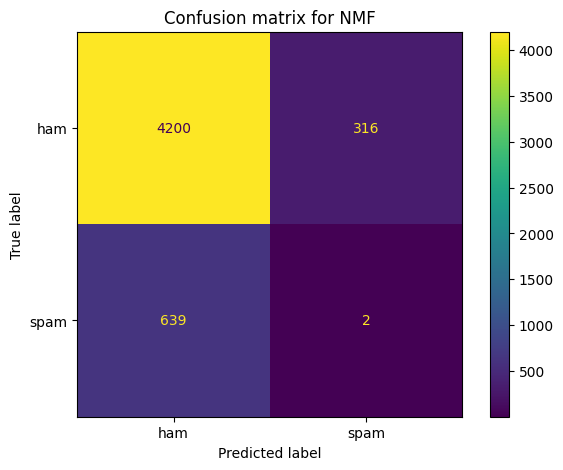

In [40]:
# plot conf matrix
f,a = plt.subplots(figsize=(7,5))
plt.title("Confusion matrix for NMF")
disp.plot(ax=a)
plt.show()

Analysis: The level of accuracy is fair, and it shows that the model works. The glaring problem with current performance is that only 2 spam messages were labeled correctly. Another observation is that there is double the amount of false negatives (spam is labeled as safe, non-spam) than there is false positives (safe is labeled as spam).

### Second model

This one is supervised learning, since the dataset comes with labels, it is good to take advantage of seeing how a different approach affects classification performance.

In [30]:
# Using random forest
rfmod = sklearn.ensemble.RandomForestClassifier()

In [31]:
# prepare data from above for modeling
res = encode.fit_transform(df['Category'].values)
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(vec_transformed,res)

In [32]:
# fit the random forest model
rfmod.fit(x_train, y_train)

RandomForestClassifier()

In [33]:
# testing the second model on test set
y_predict = rfmod.predict(x_test)

In [34]:
# showing accuracy of second model
acc = sklearn.metrics.accuracy_score(y_test, y_predict)
print("Random forest approach, accuracy level: ", acc)

Random forest approach, accuracy level:  0.9751937984496124


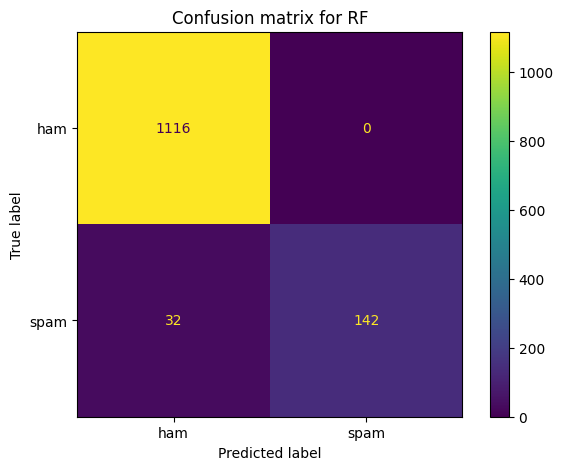

In [42]:
# Comparing results between train and test
cm_sup = sklearn.metrics.confusion_matrix(y_test, y_predict)
cm_graph = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix = cm_sup, display_labels=encode.classes_)
f, a = plt.subplots(figsize=(7,5))
cm_graph.plot(ax=a)
plt.title("Confusion matrix for RF")
plt.show()

The matrix shows very good results, and as printed above, 97.52% accuracy is very high. There are no false positives (text incorrectly labeled spam).

The splitter defaults to 25% testing, so next I will try out different splits, meaning, the training dataset will vary in size.

### 4. Optimizations

Hyperparameter tuning. Improve model performance through hyperparameter changes in the vectorizaition and model build/train.

I start with the first model.

In [20]:
# changing parameter values for the model itself
with warnings.catch_warnings():
  warnings.filterwarnings("ignore", category=ConvergenceWarning)
res = []
opts = {"n_components":["auto", 2],
        "random_state":[0, 42],
        "shuffle":[True, False],
        "solver": ["cd", "mu"],
        "beta_loss": ["frobenius", "kullback-leibler", "itakura-saito"]}

for p in sklearn.model_selection.ParameterGrid(opts):
    model_opt = NMF(random_state = p["random_state"],
                    shuffle = p["shuffle"],
                    n_components = 2,
                    solver = p["solver"]).fit(vec_transformed)

    pred_opt = model_opt.transform(vec_transformed)
    o, acc_opt = find_order(y_actual, pred_opt)

    res.append({"model": model_opt,
                "random_state": p["random_state"],
                "shuffle": p["shuffle"],
                "solver": p["solver"], "acc": acc_opt,})

df_opt = pd.DataFrame(res)
df_opt.sort_values(by='acc',ascending=False)

,model,random_state,shuffle,solver,acc
2,"NMF(n_components=2, random_state=0)",0,False,cd,0.814815
6,"NMF(n_components=2, random_state=42)",42,False,cd,0.814815
14,"NMF(n_components=2, random_state=42)",42,False,cd,0.814815
10,"NMF(n_components=2, random_state=0)",0,False,cd,0.814815
26,"NMF(n_components=2, random_state=0)",0,False,cd,0.814815
30,"NMF(n_components=2, random_state=42)",42,False,cd,0.814815
22,"NMF(n_components=2, random_state=42)",42,False,cd,0.814815
18,"NMF(n_components=2, random_state=0)",0,False,cd,0.814815
34,"NMF(n_components=2, random_state=0)",0,False,cd,0.814815
38,"NMF(n_components=2, random_state=42)",42,False,cd,0.814815


According to these optimizations, it does not matter which ones the model uses, because the accuracy is only marginally different.

Next attempt at performance increases for first model: hyperparameter tuning on the vectorizer.

In [29]:
with warnings.catch_warnings():
  warnings.filterwarnings("ignore", category=ConvergenceWarning)
res_v = []
opts = {"sublinear_tf": [True, False],
        "norm":["l2","l1"],
        "ngram_range":[(1, 2),(1,1)],
        "min_df": [1,2], "stop_words": [None, 'english'], "encoding":["latin-1","utf-8"]
}
for p in sklearn.model_selection.ParameterGrid(opts):
    vec_opt = sklearn.feature_extraction.text.TfidfVectorizer(min_df=p['min_df'],
                                                                stop_words=p['stop_words'],
                                                                sublinear_tf=p['sublinear_tf'],
                                                                norm=p['norm'],
                                                                ngram_range=p['ngram_range'],
                                                                encoding=p['encoding']).fit_transform(df.Message)

    pred_opt_v = NMF(n_components=2, random_state=42).fit_transform(vec_opt)
    o, acc_opt = find_order(y_actual, pred_opt_v)

    res_v.append({"model": model_opt, "sublinear_tf": p["sublinear_tf"],
                  "norm": p["norm"], "ngram_range": p["ngram_range"],
                  "min_df": p["min_df"],"stop_words": p["stop_words"],"encoding": p["encoding"], "acc": acc_opt,})

df_opt_v = pd.DataFrame(res_v)
df_opt_v.sort_values(by='acc',ascending=False)

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


,model,sublinear_tf,norm,ngram_range,min_df,stop_words,encoding,acc
20,"NMF(n_components=2, random_state=42, solver='mu')",True,l1,"(1, 2)",2,None,latin-1,0.831685
52,"NMF(n_components=2, random_state=42, solver='mu')",True,l1,"(1, 2)",2,None,utf-8,0.831685
53,"NMF(n_components=2, random_state=42, solver='mu')",False,l1,"(1, 2)",2,None,utf-8,0.830716
21,"NMF(n_components=2, random_state=42, solver='mu')",False,l1,"(1, 2)",2,None,latin-1,0.830716
17,"NMF(n_components=2, random_state=42, solver='mu')",False,l2,"(1, 2)",2,None,latin-1,0.830328
...,...,...,...,...,...,...,...,...
41,"NMF(n_components=2, random_state=42, solver='mu')",False,l2,"(1, 1)",1,None,utf-8,0.664534
39,"NMF(n_components=2, random_state=42, solver='mu')",False,l1,"(1, 2)",1,english,utf-8,0.643979
7,"NMF(n_components=2, random_state=42, solver='mu')",False,l1,"(1, 2)",1,english,latin-1,0.643979
6,"NMF(n_components=2, random_state=42, solver='mu')",True,l1,"(1, 2)",1,english,latin-1,0.640876


The results show a greater range of accuracies than the last round of tuning. The best accuracy is a few percentage points higher than the original training results. I will take what I can get.

The best results come from tweaking the vectorizer to use:

sublinear_tf=True,

norm=l1,

ngram_range=(1,2)

min_df=2

stop_words=None

encoding="latin-1"

Next for optimizations, I try to optimize the second model. The modifications center on ratio between test and training datasets.

In [37]:
# trying out the spectrum of training set sizes, increments of 10%

test_sizes = [.1, .2, .3, .4, .5, .6, .7, .8, .9]
features_test = vectorizing.fit_transform(df.Message)
for i in test_sizes:
  x_train_2, x_test_2, y_train_2, y_test_2 = sklearn.model_selection.train_test_split(features_test, res, test_size=i)
  rfmod.fit(x_train_2, y_train_2)
  y_predict_2 = rfmod.predict(x_test_2)
  acc_2 = sklearn.metrics.accuracy_score(y_test_2, y_predict_2)
  training_size = 100-(i*100)
  print("Random forest approach accuracy for training size = ", training_size, "% is: ", acc_2)

Random forest approach accuracy for training size =  90.0 % is:  0.9806201550387597
Random forest approach accuracy for training size =  80.0 % is:  0.9689922480620154
Random forest approach accuracy for training size =  70.0 % is:  0.9715762273901809
Random forest approach accuracy for training size =  60.0 % is:  0.9767329132331556
Random forest approach accuracy for training size =  50.0 % is:  0.9713067080263668
Random forest approach accuracy for training size =  40.0 % is:  0.9660743134087237
Random forest approach accuracy for training size =  30.0 % is:  0.9529085872576177
Random forest approach accuracy for training size =  20.0 % is:  0.9413475521085798
Random forest approach accuracy for training size =  10.0 % is:  0.9142610943558811


Analysis: Training performance improved, unsurprisingly. But more strangely, even a small 10% of the training data yielded over 90% accuracy.

The most data-efficient method of those tested was to train on 20% of the training data. The accuracy drops off after that and you will save on compute costs.

###Results

The dataset started with 5500 entries: no empty values and small percentage were duplicates, which were removed. Spam categories were distributed unevely, but the amount of text in each category started to make up for that. As with most Kaggle datasets, there was no need to transform the data.

The accuracy rate of the original model is 0.8148, which is not stellar but workable. The confusion matrix, however, showed that only 2 spam messages were labeled correctly. Also, there is double the number of false negatives (spam is labeled as safe, non-spam) than there is false positives (safe is labeled as spam).

Hyperparameter tuning resulted in slighly better accuracy. Tuning the model had marginal impact but tuning feature extraction yielded an increase to 0.8317, so almost 2%.

The best results from tuning the vectorizer used:


```
sublinear_tf=True,

norm=l1,

ngram_range=(1,2)

min_df=2

stop_words=None

encoding="latin-1"
```

The second model which used a supervised approach to contrast, yielded a very high accuracy of 0.9806.


###Conclusion:

One notable observation with the current performance of the unsupervised model is that there is double the amount of false negatives (spam is labeled as safe, non-spam) than there is false positives (safe is labeled as spam).

While the model has a passable accuracy, the high false negative rate (spam is getting through) may be too high to be usable in some scenarios. It would be usuable if the false positive reate was low but it is a significant enough that texts a user would want to see would get marked spam too often.

Lastly, labeled data works well when training a model to classify spam messages. No non-spam messages were mislabeled as spam, so a user would see all non-spam messages. The false negative rate is low but not zero, which would mean users would at least enjoy a reduced number of spam messages.

While the supervised learning method had better accuracy, it might be just short term, since scammers are constantly improving their ways. Using both unsupervised and supervised will probably be best for preventing potentially damanging text messages reaching users.

###Discussion:

 Text messages are relatively short, compared to other common text documents, like books, articles, and emails. There is less data per training sample so having many examples is very helpful for performance.

As mentioned in the conclusion, a combination of unsupervised and supervised methods to combat spam messages will most probably be most effective. While bad actors are continually figuring out how to evade spam detectors, there needs to be something place to protect users in the present, while something else is learning new evasion tactics. This is how unsupervised and supervised learning can complement each other.

### References

 https://cloud.google.com/blog/products/ai-machine-learning/problem-solving-with-ml-automatic-document-classification

https://www.kaggle.com/datasets/team-ai/spam-text-message-classification